# Spread Trading Strategy
Implementation of a spread trading strategy using the spread between the prices of two futures. The strategy is based on the assumption that the spread between the two stocks will revert to the mean. The strategy is implemented using the following steps:
- Calculate the spread between the two futures: $p_{\Delta} = R \times p_a - p_b$
- Calculate the mean and standard deviation of the spread: $\mu_{\Delta}$ and $\sigma_{\Delta}$
- Notional Exposure per synthetic contract: $= p_{\Delta} \times ($ Futures multiplier $\times$ FX rate $)$ 

**Formulas to Utilize:**
- $\sigma_{portfolio} = \sqrt{\sum_{i=1}^{n} w_i^2 \sigma_i^2 + \sum_{i=1}^{n}\sum_{j=1}^{n} w_i w_j \sigma_i \sigma_j \rho_{ij}}$
- $\rho_{ab} = \frac{Cov(a,b)}{\sigma_a \sigma_b}$
- $\sigma^{\Delta}_{p} = \sqrt{R^{2}\sigma_a^2 + \sigma_b^2 - 2 \sigma_a \sigma_b \rho_{ab}}$


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Spread of SP500 and US10Y
sp500 = pd.read_csv('sp500.csv', index_col=0, parse_dates=True)
us10 = pd.read_csv('us10.csv', index_col=0, parse_dates=True)
us5 = pd.read_csv('us5.csv', index_col=0, parse_dates=True)
sp500.tail(), us10.tail(), us5.tail()

(            adjusted  underlying
 index                           
 2022-09-26   3667.25     3667.25
 2022-09-27   3665.25     3665.25
 2022-09-28   3729.75     3729.75
 2022-09-29   3658.75     3658.75
 2022-09-30   3641.50     3641.50,
               adjusted  underlying
 index                             
 2022-09-26  111.046875  111.046875
 2022-09-27  111.031250  111.031250
 2022-09-28  112.656250  112.656250
 2022-09-29  112.140625  112.140625
 2022-09-30  112.484375  112.484375,
              Symbol                                      Security Name  \
 Date                                                                     
 2023-10-09  &ZF_CCB  5-Year U.S. T-Note Continuous Contract Backadj...   
 2023-10-10  &ZF_CCB  5-Year U.S. T-Note Continuous Contract Backadj...   
 2023-10-11  &ZF_CCB  5-Year U.S. T-Note Continuous Contract Backadj...   
 2023-10-12  &ZF_CCB  5-Year U.S. T-Note Continuous Contract Backadj...   
 2023-10-13  &ZF_CCB  5-Year U.S. T-Note Continuous Contra

In [13]:
"""
The SP500 will be our long and we will assume that the US10Y is our short
Our R-value or Ratio will be 2 to make the math easier
Our price of the spread will be the SP500 - 2 * US10Y
"""
#latest date of us10
us10_latest = us10.index.max()
us5 = us5[us5.index <= us10_latest]
ratio = 1
p_delta = us10['adjusted'] - ratio * us5['Close']
p_delta.tail()

2022-09-26    2.289062
2022-09-27    2.429688
2022-09-28    2.671875
2022-09-29    2.445312
2022-09-30    3.054688
dtype: float64

In [14]:
sp500_array = np.array(sp500['adjusted'])
us10_array = np.array(us10y['adjusted'])
us5_array = np.array(us5['Close'])
length = min(len(us5_array), len(us10_array))
us5_array = us5_array[-length:]
us10_array = us10_array[-length:]
rho = np.corrcoef(us5_array, us10_array)[0,1]
round(rho, 4)

0.9988

In [15]:
var_sp500 = np.var(sp500_array)
var_us10 = np.var(us10_array)
std_sp500 = np.std(sp500_array)
std_us10 = np.std(us10_array)
spread_risk = np.sqrt(std_sp500**2+ ratio**2 * std_us10**2 - 2 * ratio * rho * std_sp500 * std_us10)

## Usage of the Spread Trading Strategy
The spread trading strategy is implemented in the `SpreadTradingStrategy` class. 

The class takes in the following parameters:
- `futures_a`: The first future to trade
- `futures_b`: The second future to trade
- `fx_rate_a`: The FX rate of the first future
- `fx_rate_b`: The FX rate of the second future
- `multiplier_a`: The multiplier of the first future
- `multiplier_b`: The multiplier of the second future

The class has the following methods:
- `calculate_spread`: Calculates the spread between the two futures
- `calculate_mean`: Calculates the mean of the spread
- `calculate_std`: Calculates the standard deviation of the spread
- `calculate_notional_exposure`: Calculates the notional exposure of the spread
- `calculate_correlation`: Calculates the correlation between the two futures


In [16]:
class Spread:
    def __init__(self, ratio, instrument_a, instrument_b, mult_a, mult_b, fx_a=1, fx_b=1):
        self.ratio = ratio
        self.a = instrument_a
        self.b = instrument_b
        self.spread = instrument_a - ratio * instrument_b
        self.spread_price = self.a * mult_a * fx_a - ratio * mult_b * fx_b * self.b
        self.rho = np.corrcoef(instrument_a, instrument_b)[0,1]
        self.var_a = np.var(instrument_a)
        self.var_b = np.var(instrument_b)
        self.std_a = np.std(instrument_a)
        self.std_b = np.std(instrument_b)
        self.spread_risk = np.sqrt(self.std_a**2+ ratio**2 * self.std_b**2 - 2 * ratio * self.rho * self.std_a * self.std_b)
    def plot_spread(self):
        plt.plot(self.spread)
        plt.ylabel('Spread')
        plt.show()
    def calc_spread(self):
        return self.spread
    def calc_rho(self):
        return self.rho
    def calc_risk(self):
        return self.spread_risk
    def decouple(self):
        # Explore how a decoupling of a correlation affects the risk of a spread instrument
        movement = np.linspace(0, 1, 100)
        risk = []
        for i in movement:
            risk.append(np.sqrt(std_sp500**2+ ratio**2 * std_us10**2 - 2 * ratio * i * std_sp500 * std_us10))
        plt.xlabel('Coefficient of Correlation')
        plt.ylabel('Risk')
        plt.title('Risk of Spread Instrument with Decoupling of Correlation')
        plt.plot(movement, risk)
        plt.show()
    def plot_spread_price(self):
        plt.plot(self.spread_price)
        plt.ylabel('Spread Price')
        plt.show()


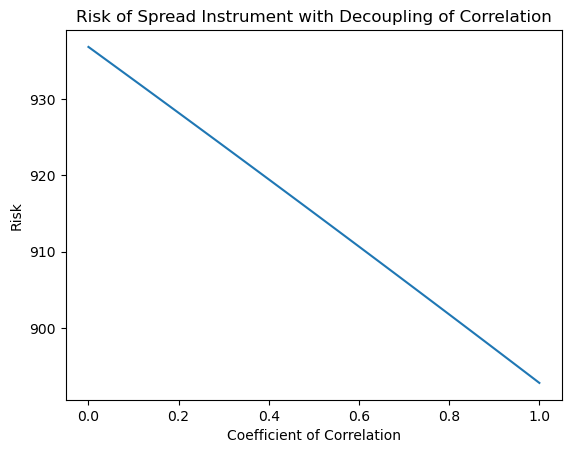

In [17]:
spread = Spread(ratio, us10_array, us5_array, mult_a=1, mult_b=1)
spread.decouple()

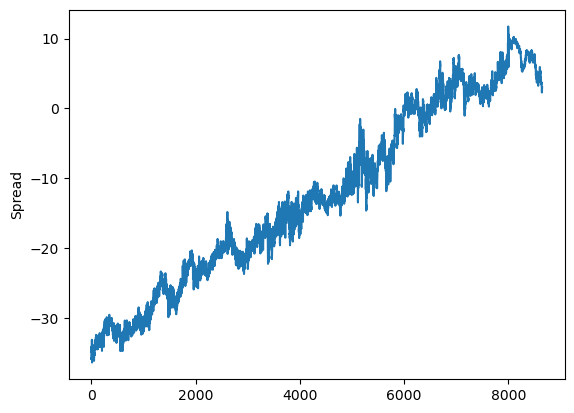

In [18]:
spread.plot_spread()

In [62]:
spread.spread_price[-1]

1391.8125